# Bayesian Experimental Design for model selection

Script used to perform optimisation where a 8 step experiment is being design considering the product of the Bhattacharyya distances of RFP and GFP for the two models

   ............................................................................................................................................................................................................................................

### Import Required libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
from numba import jit
import gaussianprocess as gp
from fitderiv import fitderiv
import genutils as gu
import datetime
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import math


### Model 1 Functions (ODEs, Steady State and Event based representation)
* Lugagne et. al. Model

In [2]:
@jit
def model1(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    
    if u_IPTG > y[0]:
        dInd_dt[0]=k_in_IPTG*(u_IPTG-y[0])
    else:
        dInd_dt[0]=k_out_IPTG*(u_IPTG-y[0])
    
    if u_aTc > y[2]:
        dInd_dt[1]=k_in_aTc*(u_aTc-y[1])
    else:
        dInd_dt[1]=k_out_aTc*(u_aTc-y[1])
    
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState1(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode1(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState1(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model1,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 2 Functions (ODEs, Steady State and Event based representation)
* Intermediate Model (Single rate, no degradation)

In [3]:
@jit
def model2(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0]);
    dInd_dt[1] = k_aTc*(u_aTc-y[1]);
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState2(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode2(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState2(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model2,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 3 Functions (ODEs, Steady State and Event based representation)
* Lucia's Model

In [4]:
@jit
def model3(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0])-0.0165*y[0];
    dInd_dt[1] = k_aTc*(u_aTc-y[1])-0.0165*y[1];
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState3(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(4)
    alpha[0] = (k_IPTG*u_IPTG)/(k_IPTG+0.0165)
    alpha[1] = (k_aTc*u_aTc)/(k_aTc+0.0165)
    alpha[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(alpha[1]/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(alpha[0]/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode3(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    
    y_al = SteadyState3(p,ivss) # Calculation of initial guesses for steady state
    
    ssv = odeint(model3,y_al,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]
        
        
        
    
    return(final)

### Functions to simulate the 3 models for all parameter draws

In [5]:
def solveALL (ts, pD, sp, inputs, ivss, pre, model):
    
    AllSol = np.empty((len(ts),len(pD[:,1])*2))
    AllSolTest = np.empty(((round(len(ts)/5)+1),len(pD[:,1])*2))
    for drawInd in range(0,len(pD[:,1])):
        
        p = pD[drawInd,:]
        if model == 'M1':
            temp = solve_coupled_ode1(ts, p, sp, inputs, ivss, pre)
        elif model == 'M2':
            temp = solve_coupled_ode2(ts, p, sp, inputs, ivss, pre)
        elif model == 'M3':
            temp = solve_coupled_ode3(ts, p, sp, inputs, ivss, pre)
        else:
            print('Please, select a correct model as M1, M2 or M3 for the desired one')

        AllSolTest[:,drawInd] = temp[:,2][::5]
        AllSolTest[:,drawInd+(len(pD[:,1]))] = temp[:,3][::5]

    return(AllSolTest)
    

### Example:

In [6]:
ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
inputs = np.empty(18) # What needs to be optimised    --> example: [1e-7,100,1,1e-7]*4+[1e-7,100]
evnT = [int(i) for i in list(np.linspace(0,(24*60),10))]
t = np.linspace(0,(24*60),(24*60)+1)
pM3 = np.asarray(pd.read_csv("ParametersCSV/draws_ALL_Model3.stan.csv"))

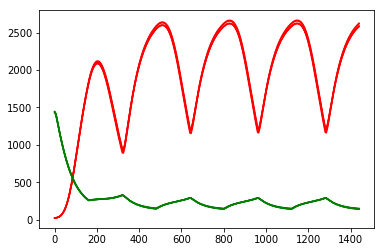

In [7]:
p = pM3[0:5,:]
test = solveALL(t,p,evnT,[1e-7,100,1,1e-7]*4+[1e-7,100],ivss,pre, 'M3')
plt.figure()
plt.plot(t[::5], test[:,0:5], 'r')
plt.plot(t[::5], test[:,5:10], 'g')
plt.show()

### Bhattacharyya distance function:

In [8]:

def BhattacharyyaDist (mu1, mu2, sd1, sd2):
    E = (sd1+sd2)/2
    Em1 = np.linalg.inv(E)
    dE = abs(np.linalg.det(E))

    t1 = np.matrix.transpose((np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))))
    t2 = np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))
    
    ft = (1/8)*t1*Em1*t2
    st = dE/np.sqrt(abs(np.linalg.det(sd1))*abs(np.linalg.det(sd2)))
    
    bhd = ft+0.5*np.log(st)
    
    return(float(bhd))



### Definition of the utility function:

In [9]:

def utility2 (IPTG1, IPTG2, IPTG3, IPTG4, IPTG5, IPTG6, IPTG7, IPTG8,
             aTc1, aTc2, aTc3, aTc4, aTc5, aTc6, aTc7, aTc8):
    
    # Definition of inputs for the ODEs
        
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7,
              round(IPTG3,2)+1e-7, int(aTc3)+1e-7, round(IPTG4,2)+1e-7, int(aTc4)+1e-7,
              round(IPTG5,2)+1e-7, int(aTc5)+1e-7, round(IPTG6,2)+1e-7, int(aTc6)+1e-7,
              round(IPTG7,2)+1e-7, int(aTc7)+1e-7, round(IPTG8,2)+1e-7, int(aTc8)+1e-7]
    
    # Initial values for steady state and inputs
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(24*60),9))]
    t =  np.linspace(0,(24*60),(24*60)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
    solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
    solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(24*60),round(24*60/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
    muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
    muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
    gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
    gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
    gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
    gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    
    g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
    bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR*bdG)

    return(u_B)
    


### Bayesian Optimisation: 

In [10]:
# Bounded region of parameter space

pbounds = {'IPTG1': (0, 1), 'IPTG2': (0, 1), 'IPTG3': (0, 1), 'IPTG4': (0, 1),
           'IPTG5': (0, 1), 'IPTG6': (0, 1), 'IPTG7': (0, 1), 'IPTG8': (0, 1),
           'aTc1': (0, 100), 'aTc2': (0, 100), 'aTc3': (0, 100), 'aTc4': (0, 100), 
           'aTc5': (0, 100), 'aTc6': (0, 100), 'aTc7': (0, 100), 'aTc8': (0, 100)}


Setting Bayesian Optimisation with our utility function

In [11]:
optimizer3 = BayesianOptimization(
    f=utility2,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1324,
) 

Begin optimisation rutine

In [25]:
optimizer3.maximize(
    init_points=0,
    n_iter=200,
    alpha=1e-2,
    n_restarts_optimizer=3, 
#     acq="ei", 
#     xi=1e-4
)

|   iter    |  target   |   IPTG1   |   IPTG2   |   IPTG3   |   IPTG4   |   IPTG5   |   IPTG6   |   IPTG7   |   IPTG8   |   aTc1    |   aTc2    |   aTc3    |   aTc4    |   aTc5    |   aTc6    |   aTc7    |   aTc8    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  805      |  4.015e+0 |  0.6525   |  0.3127   |  0.4669   |  0.8586   |  0.7033   |  0.7292   |  0.521    |  0.846    |  93.33    |  77.09    |  68.6     |  3.555    |  21.02    |  29.43    |  68.46    |  29.81    |
|  806      |  9.408e+0 |  0.6235   |  0.1954   |  0.6549   |  0.7435   |  0.4729   |  0.1823   |  0.2805   |  0.05309  |  95.05    |  52.52    |  50.63    |  43.16    |  85.04    |  5.653    |  15.52    |  40.43    |
|  807      |  1.385e+0 |  0.08455  |  0.2244   |  0.5295   |  0.4684   |  0.8434   |  0.1155   |  0.4406   |  0.04965  |  56.66

|  815      |  2.929e+0 |  0.3615   |  0.8043   |  0.6555   |  0.1873   |  0.557    |  0.09785  |  0.2291   |  0.1612   |  98.61    |  50.2     |  29.51    |  88.09    |  58.94    |  14.29    |  63.59    |  57.37    |
|  816      |  4.272e+0 |  0.2711   |  0.7518   |  0.4094   |  0.8937   |  0.4263   |  0.4423   |  0.2121   |  0.8271   |  73.34    |  78.5     |  78.33    |  64.23    |  83.99    |  69.86    |  53.55    |  72.52    |
|  817      |  4.993e+0 |  0.8443   |  0.4262   |  0.9314   |  0.1199   |  0.832    |  0.6888   |  0.1467   |  0.1689   |  99.98    |  44.88    |  19.46    |  85.1     |  59.43    |  82.92    |  77.14    |  10.74    |
|  818      |  4.486e+0 |  0.7451   |  0.5622   |  0.6522   |  0.2748   |  0.8101   |  0.0171   |  0.468    |  0.000179 |  58.78    |  84.73    |  28.3     |  56.49    |  47.04    |  45.62    |  74.21    |  57.46    |
|  819      |  4.468e+0 |  0.9773   |  0.00601  |  0.666    |  0.2201   |  0.8588   |  0.9765   |  0.3583   |  0.7731   |  5.963

|  824      |  2.3e+04  |  0.9718   |  0.4731   |  0.05538  |  0.9777   |  0.9978   |  0.2214   |  0.1912   |  0.8079   |  25.68    |  78.54    |  18.92    |  95.71    |  57.88    |  2.349    |  66.68    |  15.53    |
|  825      |  8.851e+0 |  0.4343   |  0.6236   |  0.5963   |  0.252    |  0.4824   |  0.2204   |  0.01696  |  0.2905   |  23.83    |  15.16    |  41.14    |  3.323    |  51.45    |  15.9     |  81.96    |  6.278    |
|  826      |  7.726e+0 |  0.866    |  0.392    |  0.4092   |  0.02072  |  0.8465   |  0.08438  |  0.2622   |  0.3101   |  16.85    |  54.21    |  95.76    |  82.97    |  50.0     |  35.02    |  64.16    |  54.41    |
|  827      |  8.868e+0 |  0.7999   |  0.146    |  0.01538  |  0.7397   |  0.7024   |  0.6515   |  0.1235   |  0.275    |  0.72     |  25.7     |  61.65    |  15.88    |  33.43    |  7.126    |  4.741    |  66.7     |
|  828      |  1.617e+0 |  0.2073   |  0.6706   |  0.4477   |  0.4947   |  0.8063   |  0.8044   |  0.7043   |  0.5478   |  55.34

|  834      |  1.394e+0 |  0.1255   |  0.3639   |  0.8276   |  0.4049   |  0.31     |  0.1687   |  0.5055   |  0.04654  |  54.48    |  23.29    |  95.2     |  49.01    |  96.34    |  74.92    |  71.47    |  3.378    |
|  835      |  2.429e+0 |  0.655    |  0.04296  |  0.4976   |  0.721    |  0.0989   |  0.3923   |  0.06698  |  0.7885   |  29.78    |  24.48    |  26.45    |  9.175    |  27.61    |  56.91    |  12.06    |  19.53    |
|  836      |  1.939e+0 |  0.3459   |  0.3122   |  0.5777   |  0.4544   |  0.08075  |  0.4034   |  0.4791   |  0.9643   |  25.5     |  32.52    |  83.3     |  88.46    |  59.96    |  58.44    |  45.29    |  29.27    |
|  837      |  1.301e+0 |  0.1357   |  0.8504   |  0.7193   |  0.1462   |  0.176    |  0.1214   |  0.7824   |  0.1165   |  63.21    |  59.76    |  25.25    |  96.78    |  53.92    |  0.2273   |  97.78    |  33.63    |
|  838      |  7.179e+0 |  0.6464   |  0.8616   |  0.7765   |  0.5343   |  0.3943   |  0.007003 |  0.1398   |  0.525    |  23.14

|  845      |  5.447e+0 |  0.7197   |  0.5822   |  0.3054   |  0.5349   |  0.3892   |  0.3651   |  0.613    |  0.2403   |  21.96    |  17.44    |  9.442    |  64.09    |  43.96    |  76.6     |  81.59    |  27.86    |
|  846      |  2.337e+0 |  0.6795   |  0.5673   |  0.1918   |  0.6002   |  0.9631   |  0.7623   |  0.5614   |  0.1302   |  24.93    |  42.77    |  4.071    |  12.89    |  8.862    |  56.89    |  31.93    |  15.31    |
|  847      |  1.968e+0 |  0.8815   |  0.8486   |  0.2452   |  0.9547   |  0.1103   |  0.03565  |  0.9962   |  0.6195   |  87.73    |  65.54    |  27.46    |  52.98    |  56.83    |  60.7     |  4.792    |  60.41    |
|  848      |  3.246e+0 |  0.9804   |  0.8425   |  0.3692   |  0.6347   |  0.2412   |  0.2626   |  0.3018   |  0.4901   |  54.01    |  86.07    |  18.37    |  65.66    |  51.29    |  74.01    |  80.45    |  68.99    |
|  849      |  2.482e+0 |  0.2026   |  0.455    |  0.1274   |  0.3733   |  0.3471   |  0.6209   |  0.4365   |  0.7303   |  78.76

|  854      |  1.322e+0 |  0.3892   |  0.424    |  0.4383   |  0.2393   |  0.3609   |  0.7537   |  0.4418   |  0.4331   |  17.01    |  45.92    |  40.71    |  66.22    |  40.04    |  23.66    |  62.7     |  87.31    |
|  855      |  1.687e+0 |  0.2058   |  0.2365   |  0.555    |  0.4839   |  0.07811  |  0.562    |  0.5217   |  0.7636   |  13.96    |  45.63    |  16.7     |  75.65    |  69.32    |  58.91    |  68.14    |  60.8     |
|  856      |  1.192e+0 |  0.7991   |  0.9996   |  0.5229   |  0.9461   |  0.23     |  0.6552   |  0.798    |  0.7932   |  77.18    |  24.88    |  15.79    |  65.8     |  10.18    |  14.39    |  52.67    |  68.72    |
|  857      |  3.957e+0 |  0.06273  |  0.8875   |  0.1922   |  0.5822   |  0.3459   |  0.5522   |  0.08474  |  0.5761   |  83.77    |  71.03    |  56.85    |  85.51    |  85.13    |  51.45    |  57.64    |  88.44    |
|  858      |  6.483e+0 |  0.9606   |  0.3839   |  0.59     |  0.7142   |  0.4778   |  0.4528   |  0.8991   |  0.354    |  1.586

|  865      |  4.405e+0 |  0.2862   |  0.2149   |  0.1899   |  0.6573   |  0.09899  |  0.8143   |  0.7875   |  0.7275   |  65.62    |  63.75    |  62.62    |  78.28    |  72.31    |  9.298    |  96.64    |  85.9     |
|  866      |  6.222e+0 |  0.03435  |  0.5555   |  0.964    |  0.4921   |  0.2096   |  0.4147   |  0.0465   |  0.7936   |  53.49    |  17.06    |  24.74    |  97.28    |  6.97     |  43.86    |  4.691    |  7.414    |
|  867      |  6.105e+0 |  0.9305   |  0.6382   |  0.5385   |  0.8925   |  0.4397   |  0.7504   |  0.6309   |  0.4421   |  4.007    |  28.5     |  13.11    |  7.004    |  65.39    |  60.42    |  94.33    |  79.47    |
|  868      |  1.794e+0 |  0.7731   |  0.3396   |  0.5313   |  0.8468   |  0.2312   |  0.7505   |  0.6593   |  0.7731   |  33.6     |  96.06    |  48.06    |  20.04    |  96.67    |  54.83    |  37.09    |  78.23    |
|  869      |  6.782e+0 |  0.6341   |  0.4978   |  0.9674   |  0.9924   |  0.5215   |  0.9916   |  0.09945  |  0.07255  |  20.0 

|  875      |  1.739e+0 |  0.9995   |  0.1902   |  0.1228   |  0.3591   |  0.2819   |  0.05581  |  0.5392   |  0.3081   |  13.33    |  89.08    |  28.27    |  36.67    |  86.67    |  94.81    |  46.96    |  74.46    |
|  876      |  4.779e+0 |  0.7825   |  0.8935   |  0.7135   |  0.1776   |  0.6667   |  0.9986   |  0.0913   |  0.8044   |  22.85    |  70.45    |  54.53    |  61.17    |  38.54    |  75.6     |  26.06    |  43.46    |
|  877      |  5.251e+0 |  0.4915   |  0.7865   |  0.5004   |  0.04988  |  0.1875   |  0.8789   |  0.3694   |  0.05516  |  14.38    |  61.97    |  32.15    |  52.73    |  39.11    |  99.75    |  58.06    |  24.77    |
|  878      |  8.185e+0 |  0.1189   |  0.8781   |  0.9306   |  0.08475  |  0.9975   |  0.7376   |  0.2109   |  0.4827   |  52.7     |  75.47    |  19.84    |  47.92    |  17.67    |  5.686    |  47.75    |  45.17    |
|  879      |  6.709e+0 |  0.8674   |  0.8808   |  0.8473   |  0.1093   |  0.9675   |  0.6091   |  0.8454   |  0.2237   |  83.15

|  885      |  2.9e+06  |  0.465    |  0.9537   |  0.8791   |  0.5596   |  0.6286   |  0.8982   |  0.1276   |  0.3377   |  90.21    |  7.183    |  29.77    |  49.27    |  37.8     |  0.8413   |  36.79    |  34.78    |
|  886      |  7.105e+0 |  0.6803   |  0.6894   |  0.008958 |  0.6027   |  0.7194   |  0.7239   |  0.4882   |  0.1292   |  89.22    |  13.22    |  32.48    |  39.17    |  84.1     |  86.02    |  47.2     |  71.69    |
|  887      |  8.331e+0 |  0.2897   |  0.4077   |  0.719    |  0.8913   |  0.555    |  0.4163   |  0.932    |  0.6993   |  44.07    |  59.38    |  21.1     |  46.56    |  67.05    |  89.68    |  95.59    |  53.65    |
|  888      |  1.247e+0 |  0.6217   |  0.07852  |  0.956    |  0.4192   |  0.4685   |  0.4205   |  0.4625   |  0.4274   |  33.76    |  20.24    |  12.06    |  77.39    |  60.07    |  29.3     |  88.34    |  82.75    |
|  889      |  4.149e+0 |  0.5915   |  0.4047   |  0.5418   |  0.3922   |  0.823    |  0.4749   |  0.4902   |  0.6628   |  70.05

|  896      |  3.316e+0 |  0.3016   |  0.09999  |  0.1925   |  0.8586   |  0.692    |  0.3008   |  0.9356   |  0.3409   |  96.01    |  41.49    |  34.15    |  22.38    |  35.31    |  47.15    |  67.74    |  56.96    |
|  897      |  3.783e+0 |  0.1711   |  0.3077   |  0.2123   |  0.7719   |  0.157    |  0.281    |  0.3853   |  0.6397   |  11.02    |  16.0     |  41.18    |  21.07    |  36.19    |  20.09    |  77.5     |  45.6     |
|  898      |  9.232e+0 |  0.6774   |  0.08605  |  0.2648   |  0.0799   |  0.2474   |  0.8494   |  0.6214   |  0.6191   |  39.35    |  87.76    |  5.475    |  86.22    |  29.58    |  83.05    |  23.69    |  24.48    |
|  899      |  5.088e+0 |  0.6855   |  0.681    |  0.6496   |  0.8036   |  0.8209   |  0.4216   |  0.7808   |  0.7187   |  37.91    |  75.42    |  45.31    |  11.63    |  43.32    |  2.038    |  21.83    |  97.61    |
|  900      |  1.187e+0 |  0.8144   |  0.9687   |  0.9156   |  0.002511 |  0.7718   |  0.7314   |  0.2384   |  0.3943   |  99.09

|  907      |  6.263e+0 |  0.06408  |  0.3369   |  0.305    |  0.6989   |  0.6057   |  0.7607   |  0.9031   |  0.3659   |  59.75    |  99.76    |  61.29    |  71.52    |  2.325    |  54.18    |  8.178    |  19.49    |
|  908      |  3.492e+0 |  0.681    |  0.9857   |  0.7111   |  0.46     |  0.7434   |  0.5783   |  0.7945   |  0.2626   |  64.66    |  12.8     |  76.74    |  52.82    |  91.07    |  76.41    |  78.27    |  10.19    |
|  909      |  8.469e+0 |  0.02944  |  0.3541   |  0.7465   |  0.9951   |  0.5475   |  0.949    |  0.2959   |  0.8355   |  97.92    |  70.6     |  1.567    |  29.38    |  35.82    |  8.071    |  24.75    |  77.54    |
|  910      |  1.635e+0 |  0.8032   |  0.9653   |  0.01875  |  0.4001   |  0.6526   |  0.01544  |  0.7068   |  0.8186   |  16.02    |  47.7     |  22.76    |  36.01    |  90.63    |  9.064    |  22.03    |  11.13    |
|  911      |  6.002e+0 |  0.2986   |  0.8277   |  0.6884   |  0.1939   |  0.6188   |  0.8424   |  0.02918  |  0.9457   |  41.68

|  917      |  3.376e+0 |  0.4394   |  0.9189   |  0.1566   |  0.01747  |  0.8726   |  0.2339   |  0.7653   |  0.8118   |  62.45    |  48.92    |  99.03    |  22.48    |  98.73    |  93.77    |  3.66     |  15.96    |
|  918      |  2.47e+05 |  0.9894   |  0.4036   |  0.1513   |  0.01051  |  0.9873   |  0.7317   |  0.8823   |  0.7543   |  56.13    |  53.5     |  67.1     |  72.18    |  58.42    |  83.19    |  46.39    |  8.871    |
|  919      |  4.686e+0 |  0.1802   |  0.7948   |  0.5238   |  0.7264   |  0.3333   |  0.7342   |  0.1149   |  0.6682   |  52.7     |  52.04    |  87.91    |  20.94    |  65.98    |  5.907    |  96.94    |  0.1986   |
|  920      |  6.557e+0 |  0.2735   |  0.6614   |  0.4912   |  0.269    |  0.6209   |  0.3726   |  0.09695  |  0.2636   |  0.5582   |  44.96    |  85.92    |  65.11    |  57.6     |  86.94    |  54.85    |  62.29    |
|  921      |  5.346e+0 |  0.004636 |  0.3578   |  0.04723  |  0.7547   |  0.2205   |  0.7721   |  0.5515   |  0.5295   |  99.22

|  927      |  4.156e+0 |  0.1769   |  0.1777   |  0.363    |  0.1138   |  0.9545   |  0.7632   |  0.03455  |  0.8362   |  13.11    |  92.64    |  92.46    |  14.35    |  92.68    |  96.14    |  79.79    |  55.06    |
|  928      |  9.857e+0 |  0.3038   |  0.8116   |  0.9174   |  0.8872   |  0.472    |  0.7576   |  0.2649   |  0.3059   |  70.76    |  16.38    |  60.37    |  43.1     |  49.28    |  11.0     |  77.29    |  74.29    |
|  929      |  3.629e+0 |  0.3031   |  0.6886   |  0.1926   |  0.3424   |  0.8734   |  0.3507   |  0.8426   |  0.7225   |  2.227    |  31.49    |  70.07    |  18.27    |  39.07    |  19.65    |  33.77    |  53.99    |
|  930      |  1.714e+0 |  0.2432   |  0.08794  |  0.7586   |  0.6385   |  0.2312   |  0.2327   |  0.7871   |  0.8113   |  4.243    |  80.54    |  23.34    |  76.26    |  62.22    |  19.39    |  35.23    |  9.799    |
|  931      |  1.317e+0 |  0.3149   |  0.9917   |  0.3139   |  0.8398   |  0.4028   |  0.9627   |  0.1557   |  0.9951   |  25.65

|  937      |  1.075e+0 |  0.02687  |  0.7691   |  0.3735   |  0.8898   |  0.8438   |  0.5021   |  0.4962   |  0.2721   |  71.98    |  15.37    |  62.44    |  1.041    |  72.89    |  80.39    |  66.77    |  53.73    |
|  938      |  8.575e+0 |  0.4209   |  0.3721   |  0.9905   |  0.8161   |  0.9307   |  0.466    |  0.1843   |  0.6968   |  48.1     |  57.15    |  96.34    |  20.72    |  3.907    |  87.56    |  98.08    |  83.81    |
|  939      |  3.182e+0 |  0.4882   |  0.561    |  0.5228   |  0.8533   |  0.934    |  0.9089   |  0.4406   |  0.1045   |  54.92    |  13.21    |  6.687    |  30.3     |  31.14    |  17.38    |  10.59    |  89.29    |
|  940      |  2.537e+0 |  0.768    |  0.4691   |  0.6678   |  0.3635   |  0.1794   |  0.9712   |  0.9078   |  0.3977   |  6.223    |  43.28    |  70.93    |  24.63    |  21.45    |  51.7     |  24.42    |  73.76    |
|  941      |  1.766e+0 |  0.7216   |  0.7077   |  0.7517   |  0.2271   |  0.8377   |  0.5882   |  0.3457   |  0.3089   |  63.01

|  947      |  5.113e+0 |  0.9411   |  0.02213  |  0.944    |  0.6637   |  0.1203   |  0.0313   |  0.3151   |  0.5583   |  93.73    |  46.16    |  90.82    |  30.31    |  93.24    |  8.052    |  23.23    |  45.41    |
|  948      |  4.712e+0 |  0.1942   |  0.4052   |  0.6457   |  0.1349   |  0.01275  |  0.5448   |  0.6005   |  0.9661   |  35.74    |  43.69    |  77.27    |  20.58    |  1.489    |  27.31    |  23.47    |  74.11    |
|  949      |  2.425e+0 |  0.7863   |  0.4221   |  0.02426  |  0.8332   |  0.99     |  0.6858   |  0.8099   |  0.2901   |  49.84    |  60.57    |  9.447    |  59.01    |  39.27    |  33.62    |  98.3     |  71.09    |
|  950      |  3.369e+0 |  0.4847   |  0.1363   |  0.4899   |  0.5021   |  0.5137   |  0.157    |  0.4553   |  0.3821   |  45.7     |  35.25    |  40.35    |  82.99    |  77.71    |  1.412    |  42.45    |  72.73    |
|  951      |  4.436e+0 |  0.07968  |  0.3779   |  0.3152   |  0.05448  |  0.4376   |  0.4507   |  0.5691   |  0.4924   |  87.79

|  960      |  1.085e+0 |  0.6089   |  0.3256   |  0.05518  |  0.9393   |  0.3298   |  0.7195   |  0.7985   |  0.3985   |  76.48    |  55.78    |  49.58    |  5.973    |  7.623    |  23.42    |  49.23    |  8.983    |
|  961      |  4.706e+0 |  0.2076   |  0.6257   |  0.2974   |  0.1391   |  0.8536   |  0.5662   |  0.4972   |  0.45     |  95.62    |  90.97    |  52.79    |  3.734    |  14.95    |  31.55    |  54.78    |  35.22    |
|  962      |  1.831e+0 |  0.07934  |  0.2812   |  0.2273   |  0.008308 |  0.03088  |  0.2209   |  0.6008   |  0.7279   |  9.601    |  70.01    |  48.16    |  34.04    |  89.25    |  36.41    |  14.71    |  38.38    |
|  963      |  4.355e+0 |  0.09359  |  0.05837  |  0.9687   |  0.9374   |  0.8844   |  0.5173   |  0.08719  |  0.1056   |  48.57    |  65.07    |  63.65    |  2.879    |  82.66    |  62.7     |  64.14    |  65.42    |
|  964      |  5.058e+0 |  0.8607   |  0.263    |  0.755    |  0.1219   |  0.1871   |  0.5867   |  0.8487   |  0.6891   |  86.83

|  972      |  1.151e+0 |  0.9252   |  0.5622   |  0.6244   |  0.837    |  0.2874   |  0.4446   |  0.04569  |  0.3362   |  75.84    |  71.58    |  35.09    |  50.2     |  1.494    |  36.47    |  31.02    |  94.85    |
|  973      |  6.693e+0 |  0.6551   |  0.443    |  0.4151   |  0.4898   |  0.1847   |  0.7778   |  0.2163   |  0.8687   |  95.07    |  81.38    |  15.71    |  2.825    |  14.36    |  69.43    |  43.95    |  88.8     |
|  974      |  9.275e+0 |  0.08091  |  0.9107   |  0.381    |  0.7614   |  0.8949   |  0.6755   |  0.5753   |  0.00749  |  39.07    |  41.89    |  55.39    |  53.38    |  63.49    |  8.794    |  97.85    |  14.86    |
|  975      |  1.729e+0 |  0.2117   |  0.1883   |  0.685    |  0.9682   |  0.07977  |  0.07194  |  0.5343   |  0.922    |  91.64    |  78.63    |  55.38    |  42.36    |  84.69    |  2.061    |  78.73    |  11.58    |
|  976      |  4.16e+04 |  0.6247   |  0.9095   |  0.3295   |  0.1871   |  0.8758   |  0.6981   |  0.2982   |  0.9132   |  74.23

|  983      |  1.282e+0 |  0.6985   |  0.8793   |  0.4913   |  0.4271   |  0.02265  |  0.5286   |  0.5533   |  0.8218   |  23.17    |  86.81    |  36.37    |  19.13    |  24.58    |  62.19    |  90.14    |  47.33    |
|  984      |  2.502e+0 |  0.3772   |  0.07968  |  0.7358   |  0.5786   |  0.411    |  0.4761   |  0.6209   |  0.6614   |  95.79    |  75.9     |  50.65    |  20.31    |  95.77    |  94.0     |  51.89    |  93.19    |
|  985      |  4.595e+0 |  0.02496  |  0.2526   |  0.3708   |  0.7321   |  0.5256   |  0.08952  |  0.8929   |  0.4055   |  20.7     |  50.42    |  62.85    |  82.55    |  62.3     |  72.18    |  24.73    |  96.55    |
|  986      |  1.137e+0 |  0.1915   |  0.7555   |  0.2118   |  0.4793   |  0.281    |  0.08958  |  0.6858   |  0.9532   |  39.18    |  66.66    |  6.204    |  95.86    |  48.16    |  31.89    |  32.2     |  4.37     |
|  987      |  4.238e+0 |  0.5231   |  0.08458  |  0.3927   |  0.45     |  0.559    |  0.187    |  0.3783   |  0.5335   |  94.95

|  994      |  1.819e+0 |  0.655    |  0.5222   |  0.6149   |  0.2428   |  0.1255   |  0.1722   |  0.9486   |  0.2106   |  58.15    |  39.32    |  33.16    |  34.35    |  71.92    |  83.29    |  26.44    |  10.93    |
|  995      |  5.786e+0 |  0.2014   |  0.7755   |  0.8879   |  0.4503   |  0.4476   |  0.4355   |  0.5128   |  0.3955   |  37.0     |  59.04    |  10.54    |  66.73    |  14.36    |  11.05    |  93.57    |  41.99    |
|  996      |  1.081e+0 |  0.5018   |  0.4445   |  0.2748   |  0.9398   |  0.8299   |  0.6209   |  0.9149   |  0.6256   |  41.48    |  17.02    |  54.48    |  72.88    |  4.728    |  4.837    |  73.6     |  18.75    |
|  997      |  1.648e+0 |  0.8835   |  0.4522   |  0.3392   |  0.8925   |  0.7657   |  0.7284   |  0.3595   |  0.8061   |  3.157    |  1.728    |  99.94    |  51.6     |  0.4139   |  35.63    |  22.09    |  78.94    |
|  998      |  4.188e+0 |  0.9365   |  0.1807   |  0.05397  |  0.7125   |  0.6603   |  0.2939   |  0.1248   |  0.9944   |  5.884

KeyboardInterrupt: 

In [26]:
# Save results obtained
with open('config8sMultiplicative3.optim', 'wb') as config_optim_file:
 
    pickle.dump(optimizer3, config_optim_file)
    

In [27]:
# Best utility value generated
print(optimizer3.max)

{'target': 227981628.7608451, 'params': {'IPTG1': 0.49870462615681443, 'IPTG2': 0.8333457374682331, 'IPTG3': 0.7689459788810549, 'IPTG4': 0.45865569976813647, 'IPTG5': 0.8241778905844037, 'IPTG6': 0.5880900279378812, 'IPTG7': 0.9424940626937531, 'IPTG8': 0.5662456863248144, 'aTc1': 44.78952040403404, 'aTc2': 50.862831770257664, 'aTc3': 58.3392223103054, 'aTc4': 55.35403467733042, 'aTc5': 16.66519266422062, 'aTc6': 19.2543061381933, 'aTc7': 10.990765827865312, 'aTc8': 14.778437387237952}}


Plot best utility value so far per iteration: 

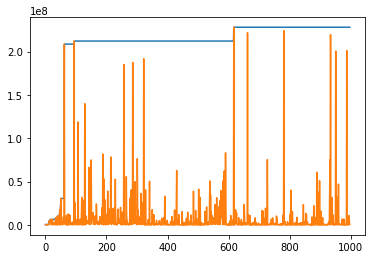

In [28]:
v = []
for i, res in enumerate(optimizer3.res):
    v.append(res['target'])
    
vn = []
for i, val in enumerate(v):
    mv = max(v[0:i+1])
    vn.append(mv)
    
plt.figure()
plt.plot(vn)
plt.plot(v)
plt.show()

In [29]:
df = pd.DataFrame({
    'CFV': v})
df.to_csv('CFV_Iter_8S_Multiplicative.csv')

df = pd.DataFrame({
    'CFV': vn})
df.to_csv('bestCFV_Iter_8S_Multiplicative.csv')

### Check results with plot

In [23]:
inputs = [round(optimizer3.max['params']['IPTG1'], 2)+1e-7, int(optimizer3.max['params']['aTc1'])+1e-7, 
          round(optimizer3.max['params']['IPTG2'], 2)+1e-7, int(optimizer3.max['params']['aTc2'])+1e-7, 
          round(optimizer3.max['params']['IPTG3'], 2)+1e-7, int(optimizer3.max['params']['aTc3'])+1e-7, 
          round(optimizer3.max['params']['IPTG4'], 2)+1e-7, int(optimizer3.max['params']['aTc4'])+1e-7, 
          round(optimizer3.max['params']['IPTG5'], 2)+1e-7, int(optimizer3.max['params']['aTc5'])+1e-7, 
          round(optimizer3.max['params']['IPTG6'], 2)+1e-7, int(optimizer3.max['params']['aTc6'])+1e-7,
          round(optimizer3.max['params']['IPTG7'], 2)+1e-7, int(optimizer3.max['params']['aTc7'])+1e-7, 
          round(optimizer3.max['params']['IPTG8'], 2)+1e-7, int(optimizer3.max['params']['aTc8'])+1e-7]

ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
sp = [int(i) for i in list(np.linspace(0,(24*60),9))]
t =  np.linspace(0,(24*60),(24*60)+1)

pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

# Simulation of the system for the two models and extract of results
solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')

RFP_M1 = solM1[:,0:len(pM1[:,1])]
GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

RFP_M2 = solM2[:,0:len(pM2[:,1])]
GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]


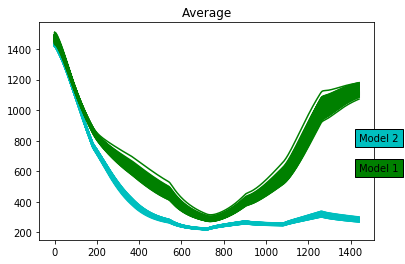

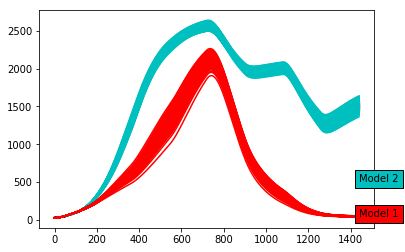

In [24]:
t = np.linspace(0,(24*60),round(24*60/5)+1)

plt.figure()
lines = plt.plot(t, GFP_M2, 'c')
plt.text((24*60)+1, 800, "Model 2", bbox=dict(facecolor='c'))
plt.title("Average")
lines2 = plt.plot(t, GFP_M1, 'g')
plt.text((24*60)+1, 600, "Model 1", bbox=dict(facecolor='g'))

plt.show()
plt.figure()
plt.plot(t, RFP_M2, 'c')

plt.text((24*60)+1, 500, "Model 2", bbox=dict(facecolor='c'))
plt.text((24*60)+1, 40, "Model 1", bbox=dict(facecolor='r'))
plt.plot(t, RFP_M1, 'r')
plt.show()

### Check utility decomposition results

In [ ]:
# Gaussian Process Regression and Reduction

# Means and standard deviations for each time point for each species and for each model
tgp = np.linspace(0,(24*60),(24*60/5)+1)

muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
sdR3 = RFP_M2.std(axis = 1)
muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
sdG3 = GFP_M2.std(axis = 1)
muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
sdR2 = RFP_M1.std(axis = 1)
muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
sdG2 = GFP_M1.std(axis = 1)

# Gaussian Process regression
gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
gR3.findhyperparameters(noruns=15)
gR3.predict(tgp)

gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
gG3.findhyperparameters(noruns=15)
gG3.predict(tgp)

gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
gR2.findhyperparameters(noruns=15)
gR2.predict(tgp)

gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
gG2.findhyperparameters(noruns=15)
gG2.predict(tgp)



In [ ]:
muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R2.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G2.predict(tref)

In [ ]:
bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
u_B = (bdR*bdG)

In [ ]:
print("The BD for RFP is: ", str(bdR))
print("The BD for GFP is: ", str(bdG))
print("The multiplicative BD is: ", str(u_B))